# IPython and cross language integration

This is demo on how cross-language integration works in a Jupyter notebook by using the features of the Reference IPython Kernel implementation.
These features are only on the Kernel basis and need to be reimplemented on a per-kernel basis. 

Most of what you will see here are thin wrappers around already existing libraries, that do all the heavy lifinting, 
we just showing how seamless a cross language environement can be. 

Understanding the multiple languages themselves is not necessary; most of the example are self explanatory and define a function that compute the nth `fibonnaci` number, either using the classic recursive implementation, or sometime using an unrolled optimized version. As a reminder the fibbonaci sequence is defines a the following:

$$ F_n = \begin{cases} 1 &\mbox{if } n \leq 2 \\ 
F_{n-1}+F_{n-2} & \mbox{otherwise }\end{cases}$$

### Not Multiple kernels

An often requested feature for the Jupyter notebook is the ability to have multiple kernels, often in many languages, for a single notebook. 

This is often a missunderstanding of what having a single kernel means. In particlular having multiple language means that you often need a single process that handle the dispatching of the instructions to the multiple underlying languages, and it is perfectly possible to do that in a Single Kernel which does orchestrate dispatching instruction and moving data around.

Wether the multiple languages that get orchestrated together are remote process, or simply library calls or more complex mechanisme becomes an implementation detail.

Python is knownto be a good "Glue" language, and over the year the IPython kernel as well has some extensions have shown that dynamic cross language integration can be seemleass form the point of view of the user.

In the followign we only scratch the surface of what is possible across a variety of languages.



In the followign you will see 2 constructs:

```
optional_python_lhs = %language (language RHS expression)
```

As well as 

```
%%language --cli like aruments
A block:
  containing expressions and statement
from another:
  language
```

# Basic Python cross-language integration

Python offer many facilities to call into other languages, wether we "shell-out"

## Steamlining calling subprocess

Well IPython define what are called Magics  `%something` for line magics, act only on the rest of the line, and call magics (start with `%%`)

In [1]:
%%ruby --out fib15
def fibonacci( n )
  return  n  if ( 0..1 ).include? n
  ( fibonacci( n - 1 ) + fibonacci( n - 2 ) )
end
puts fibonacci( 15 )

In [2]:
int(fib15.strip())

610

Ok, that's somewhat usefull, but not really that much right ? You cannot pass variable in... or can't you ? 

### Send variables in 

Calling subprocess can be quite cumbersome when workign interactively

In [3]:
import random
import string

def rand_names(k=10,l=10):
    for i in range(k):
        yield '_' + ''.join(random.choice(string.ascii_letters) for i in range(l))+'.o'
    

The `!something` expression is – for the purpose of these demo – equivalent to `%sh something` where `$variable` is looked up in `locals()` and replaced by it's `__repr__`

In [4]:
for f in rand_names():
    !touch $f

In [5]:
ls

Cargo.lock                              _cffi_FnhNIDcpiO.o
Cargo.toml                              _eqACqzSTMY.o
Cross Language Integration.ipynb        _hVjrXAWgpb.o
_GswEOhApyM.o                           _hmzfRhjfrn.o
_bGbptxCcOv.o                           _jzmUtIKXsV.o
_baTewjNLyg.o                           _nagLddUxuB.o
_bzTnvFwlBw.o                           _oIcSOdvAlz.o
_cffi_FnhNIDcpiO.c                      src/
_cffi_FnhNIDcpiO.cpython-35m-darwin.so* target/


In [6]:
files = !ls *.o
files

['_GswEOhApyM.o',
 '_bGbptxCcOv.o',
 '_baTewjNLyg.o',
 '_bzTnvFwlBw.o',
 '_cffi_FnhNIDcpiO.o',
 '_eqACqzSTMY.o',
 '_hVjrXAWgpb.o',
 '_hmzfRhjfrn.o',
 '_jzmUtIKXsV.o',
 '_nagLddUxuB.o',
 '_oIcSOdvAlz.o']

In [7]:
!rm -rf  *.{o,c,so} Cargo.* src target

_Who said I was going to use [rust-lang.org](https://www.rust-lang.org/en-US/) later ?_

In [8]:
ls

Cross Language Integration.ipynb


Ok, our directory is clean !

##  Add some state

Ok, that was kind of cute, fire-up a subprocess, serialize, pipe data in as a string, pipe-data out as a string, kill subprocess... What about somemething less state-less ?

Ok, that's pretty conveninent, it's kind-of inlineing bash-one liners where you can inject Python strin in it. 
what about multilines ? 

In [9]:
import rpy2.rinterface

In [10]:
import os

In [11]:
%matplotlib inline
import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
%load_ext rpy2.ipython
from rpy2.interactive import process_revents

In [12]:
def fib(n):
    if n<2:
        return 1
    x,y = 1,1
    for i in range(n-2):
        x,y = y,x+y
    return y

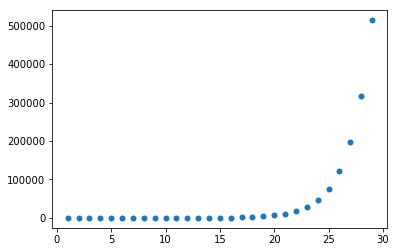

In [13]:
import numpy as np
X = np.arange(1,30)
Y = np.array([fib(x) for x in X])
import matplotlib.pyplot as plt
plt.scatter(X, Y)

In [14]:
%Rpush Y X


Call:
lm(formula = log(Y) ~ X)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.183663 -0.013497 -0.004137  0.006046  0.296094 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.775851   0.026173  -29.64   <2e-16 ***
X            0.479757   0.001524  314.84   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06866 on 27 degrees of freedom
Multiple R-squared:  0.9997,	Adjusted R-squared:  0.9997 
F-statistic: 9.912e+04 on 1 and 27 DF,  p-value: < 2.2e-16



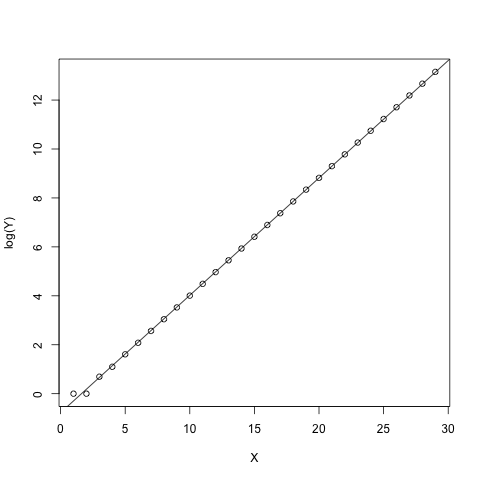

In [15]:
%%R
s = summary(lm(log(Y)~X))
val <- s$coefficients

plot(X, log(Y))
abline(s)
s

Great, we are happy as $F_n = \left[\frac{\phi^n}{\sqrt 5}\right]$, where `[]` is closest integer and $\phi = \frac{1+\sqrt 5}{2}$ 

In [16]:
%R val

array([[ -7.75850975e-01,   2.61726725e-02,  -2.96435519e+01,
          3.91031947e-22],
       [  4.79757090e-01,   1.52383191e-03,   3.14835966e+02,
          1.13718145e-49]])

In [17]:
model = lambda x: np.exp(y0+k*x)

In [18]:
coefs = %Rget val
y0,k = coefs.T[0]
y0,k

(-0.77585097534859138, 0.47975709043483161)

### What about redefinig functions ? 

# Mix and match languages: Julia

# Deep cross-language integration

# The stack as a layer cake

# CFFI

## Mix and Match : C

Expose some ability to inline C and rust through CFFI

In [24]:
import cffi_magic

In [25]:
rm -rf *.o *.c *.so Cargo.* src target

In [26]:
ls

Cross Language Integration.ipynb


In [27]:
%%cffi int cfib(int);


int cfib(int n)
{
    int res=0;
    if (n <= 2){
        res = 1;
    } else {
        res = cfib(n-1)+cfib(n-2);
    }
    return res;
}

In [28]:
cfib(4)

3

In [29]:
ls

Cross Language Integration.ipynb        _cffi_iIMSepxXju.cpython-35m-darwin.so*
_cffi_iIMSepxXju.c                      _cffi_iIMSepxXju.o


## Mix and Match : rust

In [30]:
%%rust int rfib(int);

#[no_mangle]
pub extern fn rfib(n: i32) -> i32 {
    match n {
        0 => 0,
        1 => 1,
        2 => 1,
        _ => rfib(n-1)+rfib(n-2)
    }
}

injecting  rfib in user ns


In [31]:
([rfib(i) for i in range(10)],
[cfib(i) for i in range(10)])

([0, 1, 1, 2, 3, 5, 8, 13, 21, 34], [1, 1, 1, 2, 3, 5, 8, 13, 21, 34])

### The Cake is not a lie !

In [33]:
fib(rfib(cfib(6)))

10946

In [34]:
import itertools
lookup = {'c':cfib,
       'rust': rfib,
       'python': fib}

print("Pray the demo-gods it wont segfault")

for order in itertools.permutations(lookup):
    print()
    t = 6
    for f in order:
        t = lookup[f](t)
    
    print(' -> '.join(order), ':', t)

Pray the demo-gods it wont segfault

rust -> c -> python : 10946

rust -> python -> c : 10946

c -> rust -> python : 10946

c -> python -> rust : 10946

python -> rust -> c : 10946

python -> c -> rust : 10946



### TL:DR;

    (Visualisation Side) 
      Javascript 
        -> Python 
           -> C 
             -> rust 
               -> (Julia<->Python)*N
    (Data/Computation side)
    
Note that Python Side, can use SciPy that can rely on C (again) and on Fortran.
Not shown here, communication with R, Bash, ...
    

In [19]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [20]:
%julia @pyimport matplotlib.pyplot as plt
%julia @pyimport numpy as np
%matplotlib inline

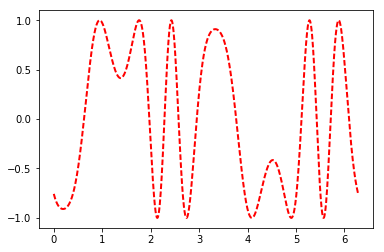

In [44]:
%%julia
# Note how we mix numpy and julia:
t = linspace(0, 2*pi,1000); # use the julia linspace
s = sin(3*t + 4*np.cos(2*t)); # use the numpy cosine and julia sine
fig = plt.gcf()  # **** WATCH THIS VARIABLE ****
plt.plot(t, s, color="red", linewidth=2.0, linestyle="--")

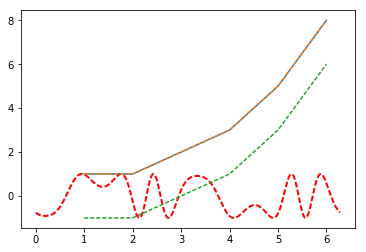

In [47]:
fig = %julia fig           # Python % Julia
fig.axes[0].plot(X[:6],(Y[:6]-2),'--')
fig                              # Python  

In [82]:
from __future__ import print_function

jlfib = %julia _fib(n, pyfib) = n < 2 ? 1 : pyfib(n-1, _fib) + pyfib(n-2, _fib)

def pyfib(n, _fib):
    print('(P', end='')
    if n < 2:
         r = n
    else:
        print('(J', end='')
        r =  _fib(n-1, pyfib) + cfib(n-2)
        print(')',end='')
    print(')',end='')
    return r

fibonacci = lambda x: pyfib(x, jlfib)

fibonacci(10)

(P(J(P(J(P(J(P(J(P(J))(P)))(P(J(P)(P)))))(P(J(P(J(P)(P)))(P(J))))))(P(J(P(J(P(J(P)(P)))(P(J))))(P(J(P(J))(P)))))))

59

In [81]:
cfib(10)

55

It's turtle, all the way down !
![attachment:fib copy.png](attachment:fib copy.png)
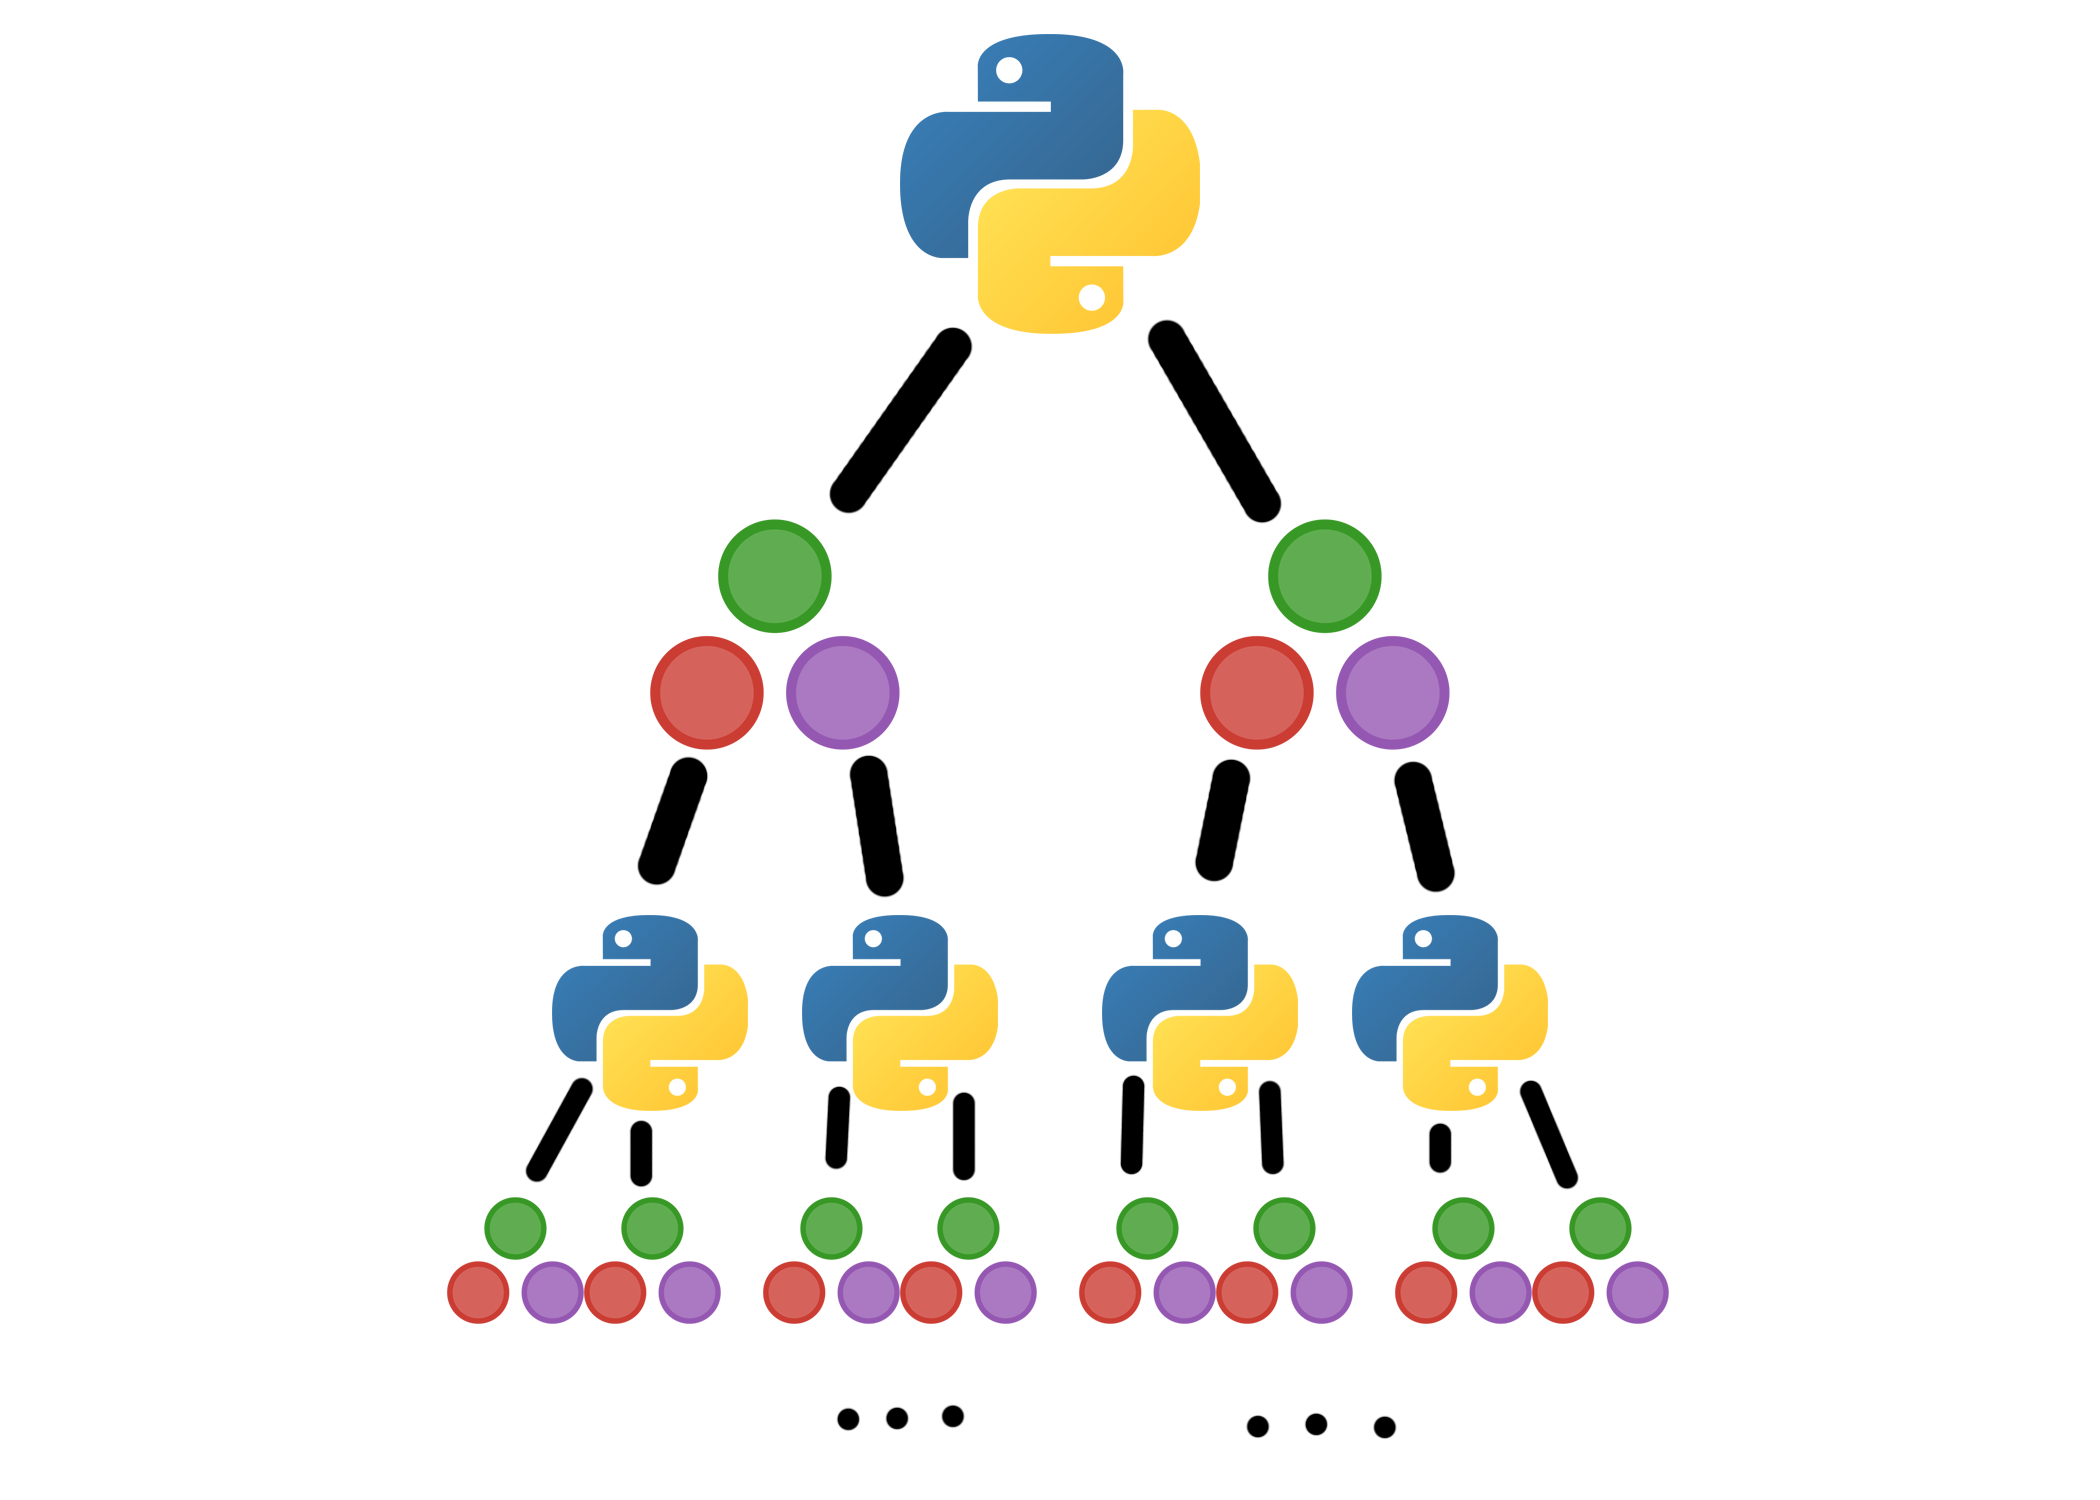